<h5>Simulating Classic Newsvendor Problem</h5>

The newsvendor problem is a classic inventory management problem that deals with the optimal order quantity for a single period of demand. The goal is to maximize expected profit by balancing the costs of overstocking and understocking.
The problem is defined by the following parameters:
- Cost of ordering (c): The cost incurred for each unit ordered.
- Selling price (p): The price at which each unit is sold.
- Salvage value (s): The value of unsold units at the end of the period.
- Mean demand (μ): The average demand for the product during the period.
- Standard deviation of demand (σ): The variability in demand during the period.
- Number of samples (n): The number of demand samples to be generated for the simulation.
- Order quantity (Q): The quantity of product ordered for the period.

The analytical solution for the optimal order quantity (Q*) is given by the following formula:<br><br>
$Q* = μ + σ * NORM.INV(\frac{Cu}{(Cu + Co)}, 0, 1)$
where:
- $Cu = p - c$: The cost of underage (profit lost for each unit not sold).
- $Co = c - s$: The cost of overage (cost incurred for each unit ordered but not sold).
- $NORM.INV$: The inverse of the standard normal cumulative distribution function.
- $Cu / (Cu + Co)$: The critical ratio, which represents the proportion of demand that should be satisfied.

For the given parameters values:
- Cost of ordering (c) = 2
- Selling price (p) = 5
- Salvage value (s) = 1
- Mean demand (μ) = 100
- Standard deviation of demand (σ) = 15
- Number of samples (n) = 1000
- Order quantity (Q) = 100

analytical solution for the optimal order quantity (Q*) is calculated using the formula:<br>
$Q* = μ + σ * NORM.INV(Cu / (Cu + Co), 0, 1)$ <br>

putting the values into the formula gives: <br>
$Q* = 100 + 15 * NORM.INV(\frac{(5 - 2)} {((5 - 2) + (2 - 1))}, 0, 1)$ <br>
$Q* = 100 + 15 * NORM.INV(\frac{3}{4}, 0, 1)$ <br>
$Q* = 100 + 15 * NORM.INV(0.75, 0, 1)$ <br>
$Q* = 100 + 15 * 0.6745$ <br>
$Q* = 100 + 10.1175$ <br>
$Q* = 110.1175$ <br>
$Q* = 110$ (rounded to the nearest integer) <br>

Similar results are obtained by running the simulation model, and shown by plotting the profit against order quantity. 

In [1]:
# Import SupplyNetPy components
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components')
import core as scm
import utilities as scm

import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

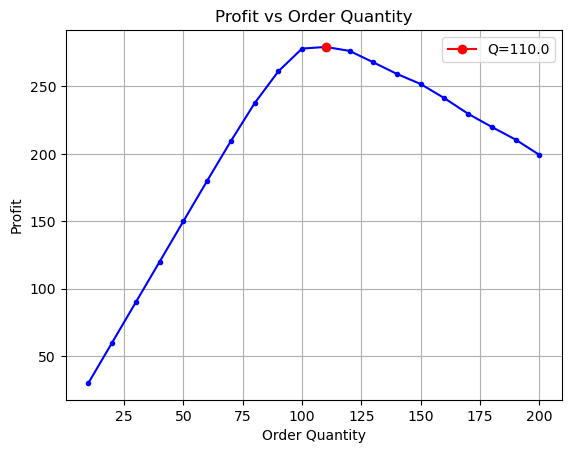

In [2]:

# Parameters for the normal distribution
mean = 100
std_dev = 15
num_samples = 1000

cost = 2
sell_price = 5
salvage = 1
cost_arr = []
profit_arr = []

order_quantity = 100

#Monte Carlo simulation for the newsvendor problem
for order_quantity in range(10, 201, 10):
    everyday_cost = 0
    everyday_profit = 0
    everyday_demand = [round(random.gauss(mean, std_dev)) for _ in range(num_samples)]
    for i in range(num_samples):
        act_order = int(everyday_demand[i]) # actual demand
        everyday_cost += order_quantity * cost
        if act_order >= order_quantity:
            everyday_profit += order_quantity * (sell_price - cost)
        else:
            everyday_profit += act_order * sell_price + (order_quantity - act_order) * salvage - (order_quantity * cost)
    # Calculate the average cost and profit
    everyday_cost = everyday_cost / num_samples
    everyday_profit = everyday_profit / num_samples

    cost_arr.append([order_quantity,everyday_cost])
    profit_arr.append([order_quantity,everyday_profit])
cost_arr = np.array(cost_arr)
profit_arr = np.array(profit_arr)

profit_arr = np.array(profit_arr)
Q = np.argmax(profit_arr[:,1])
plt.plot(profit_arr[:,0], profit_arr[:,1], marker='.', linestyle='-', color='b')
plt.plot(profit_arr[Q,0], profit_arr[Q,1], marker='o', linestyle='-', color='r', label=f'Q={profit_arr[Q,0]}')
plt.xlabel('Order Quantity')
plt.ylabel('Profit')
plt.title('Profit vs Order Quantity')
plt.legend()
plt.grid()
plt.show()

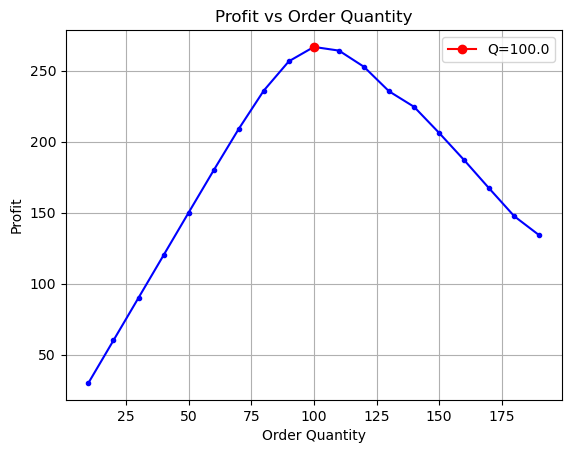

In [3]:
mean = 100
std_dev = 15
num_samples = 1000
def normal_quantity():
    """Generates a random order quantity based on a normal distribution."""
    sample = random.gauss(mean, std_dev)
    while(sample<0):
        sample = random.gauss(mean, std_dev)
    return sample

cost = 2 # newspaper buy price
sell_price = 5 # newspaper sell price
salvage = 1 # newspaper salvage price
order_quantity = 100 # initial order quantity
cost_arr = [] # to store cost for each order quantity
profit_arr = [] # to store profit for each order quantity

for order_quantity in range(10, 200, 10):

    env = simpy.Environment()

    # create an infinite supplier
    supplier1 = scm.Supplier(env=env, ID="S1", name="Supplier1", node_type="infinite_supplier")

    #create the distributor
    newsvendor1 = scm.InventoryNode(env=env, ID="D1", name="News Vendor", node_type="distributor",
                                    capacity=order_quantity, initial_level=order_quantity, 
                                    inventory_holding_cost=0.1, inventory_type="perishable", 
                                    shelf_life=1.00001, replenishment_policy=scm.PeriodicReplenishment,
                                    policy_param={"T": 1, "Q": order_quantity}, 
                                    product_sell_price=sell_price, product_buy_price=cost)

    link1 = scm.Link(env=env,ID="l1", source=supplier1, sink=newsvendor1, cost=10, lead_time=lambda: 0)
    
    demand1 = scm.Demand(env=env,ID="d1", name="demand_d1", 
                        order_arrival_model=lambda: 1, consume_available=True,
                        order_quantity_model=normal_quantity, demand_node=newsvendor1)

    scm.global_logger.disable_logging()
    env.run(until=num_samples)

    # Calculate the cost and profit
    # total demand fulfilled by newsvendor is available in variable demand_fulfilled
    # list element 0 is number of orders, element 1 is total quantity
    daily_sales = newsvendor1.stats.demand_fulfilled[1] 
    wasted_inventory = newsvendor1.inventory.waste
    everyday_profit = (daily_sales*sell_price + wasted_inventory*salvage - order_quantity*num_samples*cost)/num_samples
    profit_arr.append([order_quantity,everyday_profit])

profit_arr = np.array(profit_arr) # convert to numpy array for easier manipulation
Q = np.argmax(profit_arr[:,1]) # index of maximum profit
plt.plot(profit_arr[:,0], profit_arr[:,1], marker='.', linestyle='-', color='b')
plt.plot(profit_arr[Q,0], profit_arr[Q,1], marker='o', linestyle='-', color='r', label=f'Q={profit_arr[Q,0]}')
plt.xlabel('Order Quantity')
plt.ylabel('Profit')
plt.title('Profit vs Order Quantity')
plt.legend()
plt.grid()
plt.show()